In [1]:
import atlite
import pandas as pd
import geopandas as gpd
import xarray as xr 
import matplotlib.pyplot as plt

from bc_power import wind

In [2]:
#Here is a pre-scaled 2021 cutout
cutout_path = '../../../BC_wind_turbines_scaled_2021.nc'
cutout = atlite.Cutout(path=cutout_path)

#Configuration for running the function below
sw = 'Wind' #Choose 'Solar' or 'Wind'
name = 'Port Hardy' #Choose a name for the location
longitude = -128.003295 #Choose some longitude
latitude = 50.789021 #Choose some latitude

#Wind turbine config
oedb = 'V100/1800*134' # turbine_model_name*id ; <id> = -1 if there is only one turbine model with that name. Otherwise it is some arbitrary number
height = 80.0 #Height at which the turbine would be installed

#Solar panel config
panel_type = 'CdTe' #There are only three choices with atlite as far as I know: 'CdTe', 'KANENA', 'CSi'

In [3]:
# Used for indexing later
if sw == 'Wind':
    cap_factors = cutout.wind(turbine=wind.get_config(oedb, height), capacity_factor=True)
elif sw == 'Solar':
    cap_factors = cutout.pv(panel=panel_type, orientation='latitude_optimal', capacity_factor=True)

# This code calculates the cells/grids for where generation exists
# Cells of the cutout
cells = cutout.grid 

#site: location of the termines with latitudes and longitudes specified
sites = gpd.GeoDataFrame([[name, longitude, latitude, 1]], # name, lon, lat, capacity
                         columns=['name', 'lon', 'lat', 'capacity']
                         ).set_index('name')

# Finds cutout cells nearest to (lat,lon) of each site 
# (x,y) of cells/grids are the center points by default and correspong to (lat,lon) of the cells.
nearest = cutout.data.sel(
    {'x': sites.lon.values, 'y': sites.lat.values}, 'nearest').coords

# Add new columns for the grid (x,y) where each generator falls.
sites['x'] = nearest.get('x').values
sites['y'] = nearest.get('y').values

# Performs an inner join on the (x,y) values
cells_generation = sites.merge(
    cells, how='inner').rename(pd.Series(sites.index))

# Layout indicates the installed capacity and grid location of installed capacity
layout = xr.DataArray(cells_generation.set_index(['y', 'x']).capacity.unstack())\
                    .reindex_like(cap_factors).rename('Installed Capacity [MW]')

# Finally generate the power produced at these sites
# Returns the power generation of the generators for each location
# The data is returned as an xarray with shape of (timesteps, generators)
if sw == 'Wind':
    power_generation = cutout.wind(turbine=wind.get_config(oedb, height),
                                    layout = layout,
                                    shapes = cells_generation.geometry,
                                    per_unit = False) # currently using per-unit
elif sw == 'Solar':
    power_generation = cutout.pv(panel=panel_type, 
                                    orientation='latitude_optimal',
                                    layout = layout,
                                    shapes = cells_generation.geometry,
                                    per_unit = False) # currently using per-unit

gen = power_generation.to_pandas()
gen

No hub_height defined in dataset. Manual clean-up required.Assuming a hub_height of 100m for now.
No hub_height defined in dataset. Manual clean-up required.Assuming a hub_height of 100m for now.


dim_0,Port Hardy
time,
2021-01-01 00:00:00,0.924167
2021-01-01 01:00:00,0.994142
2021-01-01 02:00:00,0.998839
2021-01-01 03:00:00,1.000000
2021-01-01 04:00:00,1.000000
...,...
2021-12-31 19:00:00,0.150315
2021-12-31 20:00:00,0.102691
2021-12-31 21:00:00,0.039646


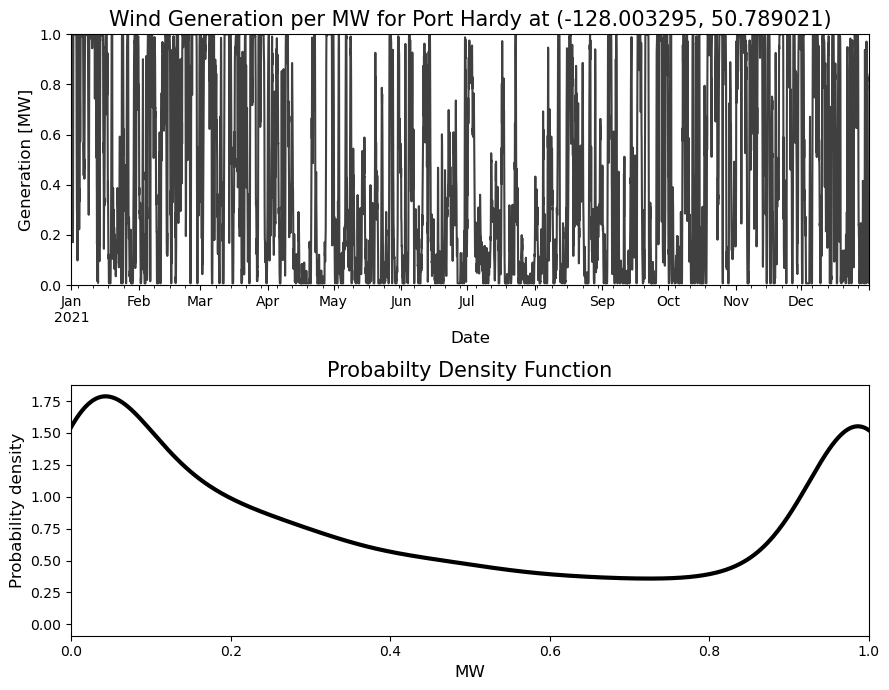

In [12]:
# Plot of the power generation
fig, axes = plt.subplots(len(sites) + 1, sharex=False, figsize=(9, 7))
p_title = sw + ' Generation per MW for ' + name + ' at (' + str(longitude) + ', ' + str(latitude) + ')'
gen.plot(subplots=True, ax=axes[0], legend=False, color='black', alpha=0.75)
axes[0].set_ylim([0, 1])
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Generation [MW]', fontsize=12)
axes[0].set_title(p_title, fontsize=15)

p_title = 'Probabilty Density Function'
gen.plot(subplots=True, ax=axes[1], legend=False, kind='kde', color='black', linewidth=3)
axes[1].set_xlim([0, 1])
axes[1].set_xlabel('MW', fontsize=12)
axes[1].set_ylabel('Probability density', fontsize=12)
axes[1].set_title(p_title, fontsize=15)

fig.tight_layout()

plt.show()